In [1]:
import sys
sys.path.append("../")

from image_store import ImageStore
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
import numpy as np

config = json.load(open("../config.json"))
store = ImageStore.read(config["STORE_DIR"])

In [2]:
def select(clusters, transformed):
    (points, weights, indices, 
     nans, nans_index, selected) = ([], [], [], [], [], [])
    
    for cluster in np.unique(clusters):
        cluster_points_index = np.where(clusters == cluster)[0]
        cluster_points = transformed[cluster_points_index]

        if cluster != -1 and cluster_points.shape[0] > 2:
            hull = ConvexHull(cluster_points)
            hull_surface = hull.points[hull.vertices]
            hull_size = hull.vertices.shape[0]

            weights.append((np.arange(0, 1, 1/hull_size) + 
                            np.random.normal(0, 1/hull_size/5, hull_size))
                           [np.random.permutation(hull_size)])
            indices.append(cluster_points_index[hull.vertices])
        else:
            nans_index.append(cluster_points_index)
    
    if len(nans) != 0:
        nans_index = np.concatenate(nans_index)
        nans_index = nans.shape[0]
        print("nans_index.shape  ->", nans_index.shape)
        weights.append(((np.arange(0, 1, 1/nans_size) + 
                         np.random.normal(0, 1/nans_size/5)) / 4)
                       [np.random.permutation(nans_size)])
        indices.append(nans_index)

    weights, indices = np.concatenate(weights), np.concatenate(indices)
    return indices[weights.argsort()]

In [3]:
tsne = TSNE(n_components=2, init="pca", random_state=100, method="exact")
pca = PCA(n_components=2)

dbscan = DBSCAN(eps=0.425, min_samples=2)
kmeans = KMeans(n_clusters=8, init="k-means++")

clusters = dbscan.fit_predict(store.encs)
transformed = tsne.fit_transform(store.encs)

indices = select(clusters, transformed)
print()
print("len(indices)      ->", len(indices))


len(indices)      -> 165


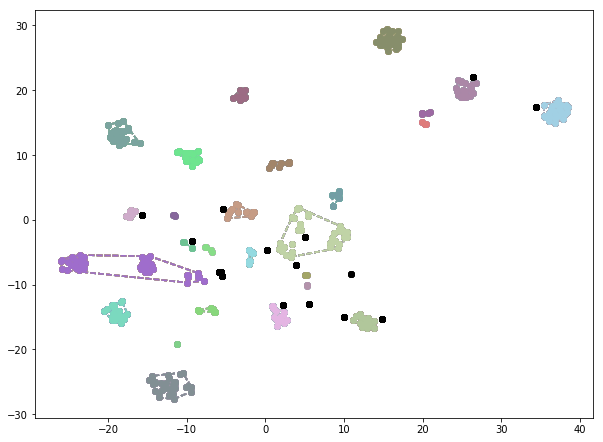

In [4]:
plt.figure(figsize=(10, 7.5))
for i, cluster in enumerate(clusters):
    cluster_points_index = np.where(clusters == cluster)[0]
    cluster_points = transformed[cluster_points_index]
    
    if cluster != -1 and cluster_points.shape[0] > 2:
        color = np.random.uniform(0.4, 0.9, size=(3,))
        hull = ConvexHull(cluster_points)
        hull_surface = hull.points[hull.vertices]
        hull_size = hull_surface.shape[0]
        
        plt.plot(hull_surface[:, 0], hull_surface[:, 1], "--", c=color)
        plt.plot(hull_surface[(-1, 0), 0], hull_surface[(-1, 0), 1], "--", c=color)
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=color)
    else:
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=(0, 0, 0))

In [5]:
indices

array([125, 104, 385,  40, 135, 116,  62,  85,  42, 156, 358, 120, 391,
         8, 243, 202, 222, 318,  21,  54, 376,  88, 286, 173, 332, 402,
       223, 282,   1,  63, 319, 341,  57, 130, 213,  91,  60, 193,  45,
       106, 396, 200, 100, 386, 353, 373, 160,  83, 114, 157, 232,  22,
         6, 302, 245, 179,  64, 342, 369,  47, 383,  95,  56,  24, 355,
       321, 218, 107, 289,  77, 161,  39, 118, 258, 211, 392, 313, 178,
       242, 109, 188, 133,   4, 113, 359, 217, 377, 136, 299, 336, 142,
       384, 172, 400, 206, 308, 117, 408, 401,   2,  46, 329,  84, 229,
       257,  48, 103,  34,  31,  23, 201, 281, 170,  41, 312,  14, 194,
        89, 152,  36, 371,  15, 389, 285, 219, 123, 246,  52, 159, 119,
       333, 322, 176, 141, 101, 356,  16, 382, 171, 129, 240, 301, 208,
       275, 149,  50, 185,  59, 380, 163, 215, 387, 344, 140, 335, 288,
       115, 228,  97,  11,  92, 205, 314,  53, 365])

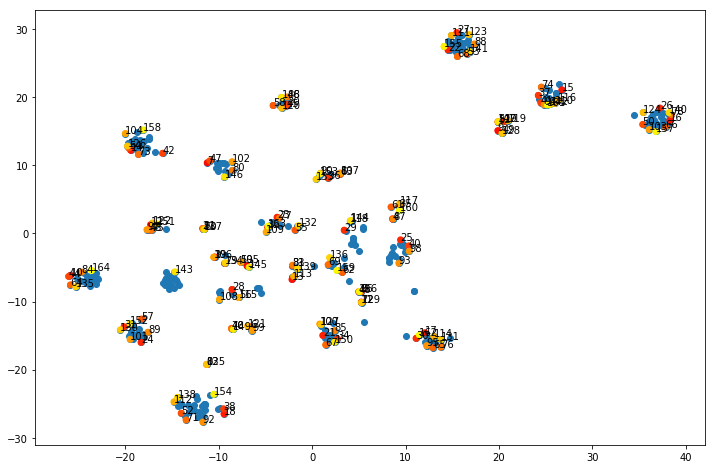

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(transformed[:, 0], transformed[:, 1])
points = transformed[indices]
plt.scatter(points[:, 0], points[:, 1], c=np.arange(points.shape[0]), cmap=plt.get_cmap("autumn"))
for i, point in enumerate(points):
    plt.annotate(i, point)
display()

In [7]:
from image_store import ImageStore
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from functools import partial
import pandas as pd
import numpy as np
import json

config = json.load(open("../config.json"))
store = ImageStore.read(config["STORE_DIR"])

param_dict = {
    "min_samples": range(2, 10),
    "eps": np.arange(0.25, 0.775, 0.025)
}

def rand_score(estimator, X, labels_true=None):
    labels_pred = estimator.fit_predict(X)
    return adjusted_rand_score(labels_true, labels_pred)

cv = [(slice(None), slice(None))]

mask = store.info["verified"].values
X, y = store.encs[mask, :], pd.Categorical(store.info.subject).codes
    
gs = GridSearchCV(estimator=DBSCAN(), param_grid=param_dict, 
                  scoring=partial(rand_score, labels_true=y),
                  cv=cv, n_jobs=-1)

gs.fit(X)

scoring_frame = pd.DataFrame(gs.cv_results_["params"])
scoring_frame["scores"] = gs.cv_results_["split0_train_score"]
display(scoring_frame)

labels_pred, labels_true = gs.best_estimator_.fit_predict(X), y
order = labels_true.argsort()
labels_true, labels_pred = labels_true[order], labels_pred[order]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(np.stack((labels_pred, labels_true)).T, 
                         columns=["labels_pred", "labels_true"]))


/home/pushkar/anaconda3/envs/Intangles-DL/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,eps,min_samples,scores
0,0.250,2,0.188374
1,0.250,3,0.143882
2,0.250,4,0.099421
3,0.250,5,0.083125
4,0.250,6,0.064373
5,0.250,7,0.061070
6,0.250,8,0.056229
7,0.250,9,0.055442
8,0.275,2,0.291502
9,0.275,3,0.236390


,labels_pred,labels_true
0,21,0
1,21,0
2,1,0
3,21,0
4,1,0
5,1,0
6,1,0
7,1,0
8,21,0
9,11,1


In [8]:
from scipy.spatial import distance_matrix

In [9]:
import seaborn as sns

In [10]:
def make_dist_mat(encs, pred, label):
    return distance_matrix(encs[pred == label], encs[pred == label])

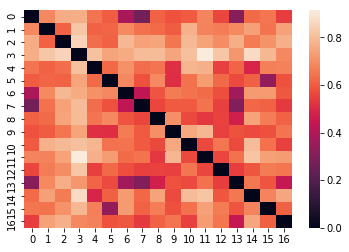

In [27]:
sns.heatmap(make_dist_mat(store.encs, labels_pred, 33))

In [14]:
gs.best_score_

0.854799293987552

In [28]:
gs.best_estimator_

DBSCAN(algorithm='auto', eps=0.3750000000000001, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=2, n_jobs=None,
    p=None)